In [ ]:
!pip install textdistance
!pip install fuzzywuzzy
!pip install phonetics
!pip install scikit-learn
!pip install matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for phonetics: filename=phonetics-1.0.5-py2.py3-none-any.whl size=8696 sha256=cb9b20dd9f534ec305ce05b27128682bfbd9e9163969f14a6705c945e5575f85
  Stored in directory: /root/.cache/pip/wheels/b7/1e/82/80a78c7d1ad7fc6e0af1b4d9009360b251c0e50fe59f046edb
Successfully built phonetics


In [ ]:
import re
import pandas as pd
from fuzzywuzzy import fuzz
import textdistance
import phonetics

def clean_name(name):
  # remove non-alphabetic characters
  cleaned_name = re.sub(r'[^a-zA-Z\s]', '', name.lower())
  # remove titles
  honorifics_pattern = r"\b(Mr|Mrs|Ms|Miss|Dr|Prof|Sir|Dame|Lord|Lady|Hon|Rev)\b"
  cleaned_name = re.sub(honorifics_pattern, "", cleaned_name, flags=re.IGNORECASE).strip()
  return cleaned_name

def compute_soundex_similarity(name1, name2):
  formatted_name1 = name1.replace(" ", "")
  formatted_name2 = name2.replace(" ", "")
  return 1 if  (phonetics.soundex(formatted_name1) == phonetics.soundex(formatted_name2)) else 0

def compute_double_metaphone_similarity(name1, name2):
  primary1, secondary1 = phonetics.dmetaphone(name1)
  primary2, secondary2 = phonetics.dmetaphone(name2)
  return 1 if (primary1 == primary2 or primary1 == secondary2 or secondary1 == primary2 or secondary1 == secondary2) else 0

def is_initials_only(name):
  parts = name.split()
  return all(len(part) == 1 for part in parts)

def preprocess_initials(name):
  initials = "".join([word[0] for word in name.split()]).lower() # remove space
  return "".join(sorted(initials)) # sort the letters to handle 'out of order components'

def similarity_based_on_intials(name1, name2):
  at_least_one_is_all_intials = is_initials_only(name1) or is_initials_only(name2)
  is_similar = False

  if at_least_one_is_all_intials :
    name1_as_initials = preprocess_initials(name1)
    name2_as_initials = preprocess_initials(name2)
    initials_with_lesser_chars = name1_as_initials if len(name1_as_initials) <= len(name2_as_initials) else name2_as_initials

    if (len(initials_with_lesser_chars) == 1):
      is_similar = True
    else:
      is_similar = len(set(name1_as_initials).intersection(set(name2_as_initials))) > 0 # at least on initial is common

  return at_least_one_is_all_intials, is_similar

def has_one_word(name1, name2):
  splitted_name1 = name1.split(" ")
  splitted_name2 = name2.split(" ")
  if (len(splitted_name1) == 1):
    return True, name1, splitted_name2
  elif (len(splitted_name1) == 1):
    return True, name2, splitted_name1
  return False, "", []

def compute_similarity_score(name1, name2):
  # preprocess names
  name1 = clean_name(name1)
  name2 = clean_name(name2)

  # check if any of the names are completely initials and compute score accordingly
  at_least_one_is_all_intials, are_initials_similar = similarity_based_on_intials(name1, name2)
  if (at_least_one_is_all_intials):
    return 1 if are_initials_similar else 0

  # scores from algos of distance
  jaro_winkler_score = textdistance.jaro_winkler.normalized_similarity(name1,name2)
  cosine_score = textdistance.cosine.normalized_similarity(name1, name2)
  partial_score = (fuzz.partial_ratio(name1, name2)) / 100
  token_set_score = (fuzz.token_set_ratio(name1, name2)) / 100
  # scores based on phonetic algorithms
  soundex_score = compute_soundex_similarity(name1, name2)
  double_metaphone_score = compute_double_metaphone_similarity(name1, name2)

  scores = [jaro_winkler_score, cosine_score, partial_score, token_set_score,soundex_score, double_metaphone_score]
  # overall_score = sum(scores) / len(scores) # average
  overall_score = max(scores)
  return overall_score # final score

def predict_similarity(name1, name2):
  has_one_word_in_name, one_word_name, multi_word_name = has_one_word(name1, name2)

  if has_one_word_in_name:
    similarity_score = 0
    for word in multi_word_name:
      similarity_score = max(compute_similarity_score(name1, name2), similarity_score)
    return similarity_score

  else:
    return compute_similarity_score(name1, name2)



In [ ]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

def plot_confusion_matrix(df):
  # Actual vs Predicted labels
  y_true = df['actual_label']
  y_pred = df['predicted_label']

  # Confusion Matrix
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap='Blues')
  plt.title("Confusion Matrix for Similarity Thresholding")
  plt.show()

  # Classification Report
  print(classification_report(y_true, y_pred))

def plot_roc_auc_curve(df):
  # Calculate FPR, TPR, and thresholds
  y_true = df['actual_label']
  y_scores = df['similarity_score']
  fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()

  print(f"ROC-AUC Score: {roc_auc:.2f}")


def plot_precision_recall_curve(df):
  # Extract the actual labels and similarity scores
  y_true = df['actual_label']
  y_scores = df['similarity_score']

  # Calculate precision, recall, and thresholds
  precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)

  # Plot precision-recall curve
  plt.figure(figsize=(8, 6))
  plt.plot(recall, precision, marker='.', color='b', label="Precision-Recall curve")
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend()
  plt.show()

In [ ]:
SIMILARITY_THRESHOLD = 0.40

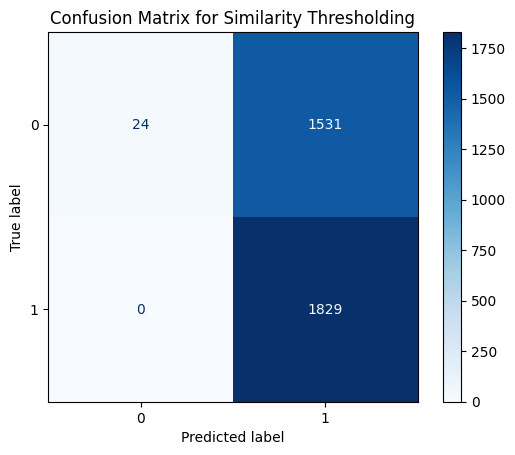

              precision    recall  f1-score   support

           0       1.00      0.02      0.03      1555
           1       0.54      1.00      0.70      1829

    accuracy                           0.55      3384
   macro avg       0.77      0.51      0.37      3384
weighted avg       0.75      0.55      0.39      3384



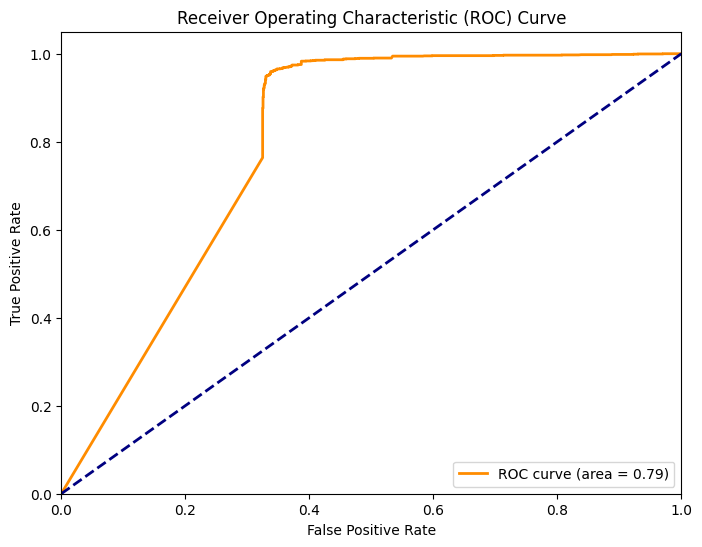

ROC-AUC Score: 0.79


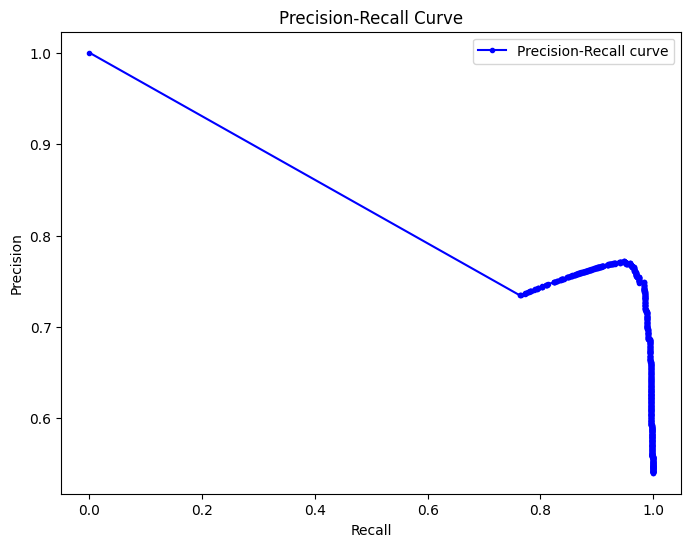

In [ ]:
training_dataset = pd.read_csv("/content/sample_data/training_dataset.csv")
training_dataset['similarity_score'] = training_dataset.apply(lambda row: predict_similarity(row['name1'], row['name2']), axis=1)
training_dataset['predicted_label'] = training_dataset.apply(lambda row: 1 if row['similarity_score'] >= SIMILARITY_THRESHOLD else 0, axis=1)

plot_confusion_matrix(training_dataset)
# # plot ROC-AUC curve
plot_roc_auc_curve(training_dataset)

# # plot precision-recall curve
plot_precision_recall_curve(training_dataset)